**Run the code cell below** to import the needed libraries.

In [53]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import json
import os
from os import listdir
import cv2
from PIL import Image
import seaborn as sns
sns.set()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

**Run the code cell below** to intialize all the variables.

In [35]:
base_path = "D:/university/concordia/Winter 22/Machine Learning/Project/breast cancer"
dataset_path = base_path + "/dataset/"

# VGG16
vgg16_model_path = "VGG16_model.h5"
vgg16_model_plot_path = "vgg16_model.png"
vgg16_model_history_path = "vgg16_history.json"

# Load Dataset and Preprocess Data

Creating root dataframe with all data including the information of their patient id, image path and target.

In [28]:
folder = listdir(dataset_path)

total_images = 0
for n in range(len(folder)):
    patient_id = folder[n]
    for c in [0, 1]:
        patient_path = dataset_path + patient_id 
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        total_images += len(subfiles)

data = pd.DataFrame(index=np.arange(0, total_images), columns=["patient_id", "path", "target"])

k = 0
for n in range(len(folder)):
    patient_id = folder[n]
    patient_path = dataset_path + patient_id 
    for c in [0,1]:
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        for m in range(len(subfiles)):
            image_path = subfiles[m]
            data.iloc[k]["path"] = class_path + image_path
            data.iloc[k]["target"] = c
            data.iloc[k]["patient_id"] = patient_id
            k += 1  

data.head()

,patient_id,path,target
0,10253,D:/university/concordia/Winter 22/Machine Lear...,0
1,10253,D:/university/concordia/Winter 22/Machine Lear...,0
2,10253,D:/university/concordia/Winter 22/Machine Lear...,0
3,10253,D:/university/concordia/Winter 22/Machine Lear...,0
4,10253,D:/university/concordia/Winter 22/Machine Lear...,0


First create non_cancer_data & cancer_data. Then, merged them in sliced_data.

In [40]:
non_cancer_data = data.query("target == 0").head(2000)
print(non_cancer_data['target'].value_counts())
cancer_data = data.query("target == 1").head(2000)
print(cancer_data['target'].value_counts())
sliced_data = pd.concat([non_cancer_data,cancer_data])
print(sliced_data['target'].value_counts())

0    2000
Name: target, dtype: int64
1    2000
Name: target, dtype: int64
1    2000
0    2000
Name: target, dtype: int64


In [41]:
print(sliced_data['target'].value_counts())

1    2000
0    2000
Name: target, dtype: int64


In [42]:
sliced_data.target.unique()

array([0, 1], dtype=object)

In [43]:
sliced_data.shape

(4000, 3)

In [44]:
sliced_data.head()
sliced_data.loc[:, "target"] = data.target.astype(np.str)
sliced_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 0 to 9253
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  4000 non-null   object
 1   path        4000 non-null   object
 2   target      4000 non-null   object
dtypes: object(3)
memory usage: 125.0+ KB


In [45]:
unique_paths = sliced_data.path.unique()

In [46]:
sub_train_ids, test_ids = train_test_split(unique_paths,
                                           test_size=0.2,
                                           random_state=0)
train_ids, valid_ids = train_test_split(sub_train_ids, test_size=0.1, random_state=0)

In [47]:
print(f"Now, we're taking {round(len(train_ids)/unique_paths.shape[0]*100, 1)}% for training, {round(len(valid_ids)/unique_paths.shape[0]*100,1)}% for validation, {round(len(test_ids)/unique_paths.shape[0]*100,1)}% for testing")

Now, we're taking 72.0% for training, 8.0% for validation, 20.0% for testing


In [48]:
print(f'{len(train_ids)}, {len(valid_ids)}, {len(test_ids)}')

2880, 320, 800


In [49]:
train_df = sliced_data.loc[sliced_data.path.isin(train_ids),:].copy()
test_df = sliced_data.loc[sliced_data.path.isin(test_ids),:].copy()
valid_df = sliced_data.loc[sliced_data.path.isin(valid_ids),:].copy()

print(f"train set shape: {train_df.shape}")
print(f"test set shape: {test_df.shape}")
print(f"validation set shape: {valid_df.shape}")

train set shape: (2880, 3)
test set shape: (800, 3)
validation set shape: (320, 3)


Reseting index for each dataset. Because, we're creating three dataset by slicing the root dataframe. After slicing it, each dataset's index will be scattered and will have the index of root dataframe.

In [50]:
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)

Creating image data generator for each dataset

In [51]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40, 
                                   width_shift_range = 0.2, 
                                   height_shift_range = 0.2, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   horizontal_flip = True, 
                                   vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255)

In [52]:
target_size = (224,224)
batch_size = 64

In [53]:
train_batches = train_datagen.flow_from_dataframe(
    train_df,
    x_col = 'path', 
    y_col ='target',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
)

valid_batches = valid_datagen.flow_from_dataframe(
    valid_df,
    x_col = 'path', 
    y_col ='target',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
)

test_batches = test_datagen.flow_from_dataframe(
    test_df,
    x_col = 'path', 
    y_col ='target',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
)

Found 2880 validated image filenames belonging to 2 classes.
Found 320 validated image filenames belonging to 2 classes.
Found 800 validated image filenames belonging to 2 classes.


### Target distributions 
Let's take a look at the target distribution difference of the datasets:

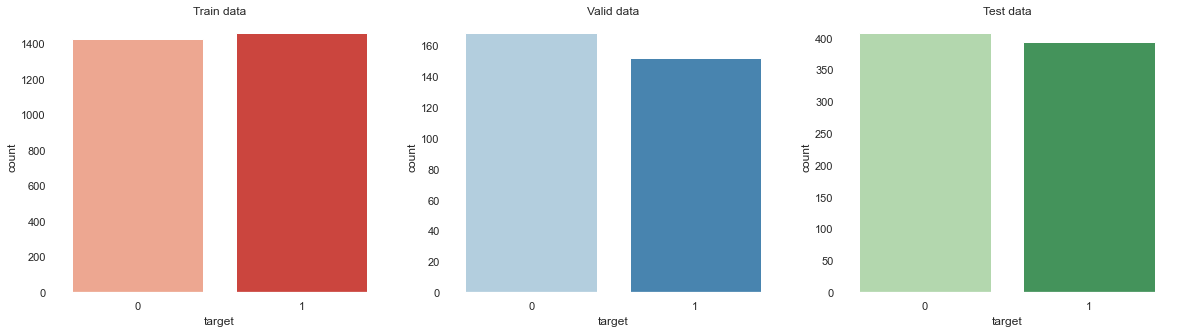

In [54]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.countplot(train_df.target, ax=ax[0], palette="Reds")
ax[0].set_title("Train data")
sns.countplot(valid_df.target, ax=ax[1], palette="Blues")
ax[1].set_title("Valid data")
sns.countplot(test_df.target, ax=ax[2], palette="Greens");
ax[2].set_title("Test data");

# VGG16

### Model Creation

The following functions will be useful to create a VGG16 model. The function  `create_vgg16_model` will create/load a VGG16 model.


**Run the code cell below** to create a model. 

In [29]:
def create_vgg16_model(model_path=None):
    """breif description.
    
    Arguments
    ---------
    model_path : String
      String containing the path of a model.
    
    Returns
    ---------
    vgg_model: keras.engine.functional.Functional
      Model containing .... 
    """
    if model_path:
        return tf.keras.models.load_model(model_path)
    else:
        """ Load VGG model with imagenet trained weights and pass our input shape . """
        base_model = tf.keras.applications.vgg16.VGG16(
            weights='imagenet', # Load weights pre-trained on ImageNet.
            input_shape=(224, 224, 3),
        )
        
        """ Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights. """
        for layer in base_model.layers:
            layer.trainable = False
        
        """ Add all layers to model except the output layer. """
        new_model = keras.models.Sequential()
        new_model._name="VGG16"
        
        for layer in base_model.layers[0:-1]:
            new_model.add(layer)
            
        """ Add all layers to model except the output layer. """
        new_model.add(layers.Dense(1, activation="sigmoid", name='output'))
        
        return new_model
        
vgg_model = create_vgg16_model(vgg16_model_path)

### Model Summary

**Run the code cell below** to create a summary of our model. 

In [30]:
print(type(vgg_model))
vgg_model.summary()

<class 'keras.engine.sequential.Sequential'>
Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (C

### Model Plotting
**Run the code cell below** to create a plot of a model and download it. 

*Make sure you have installed `pydot` & `graphviz` for plot_model.*

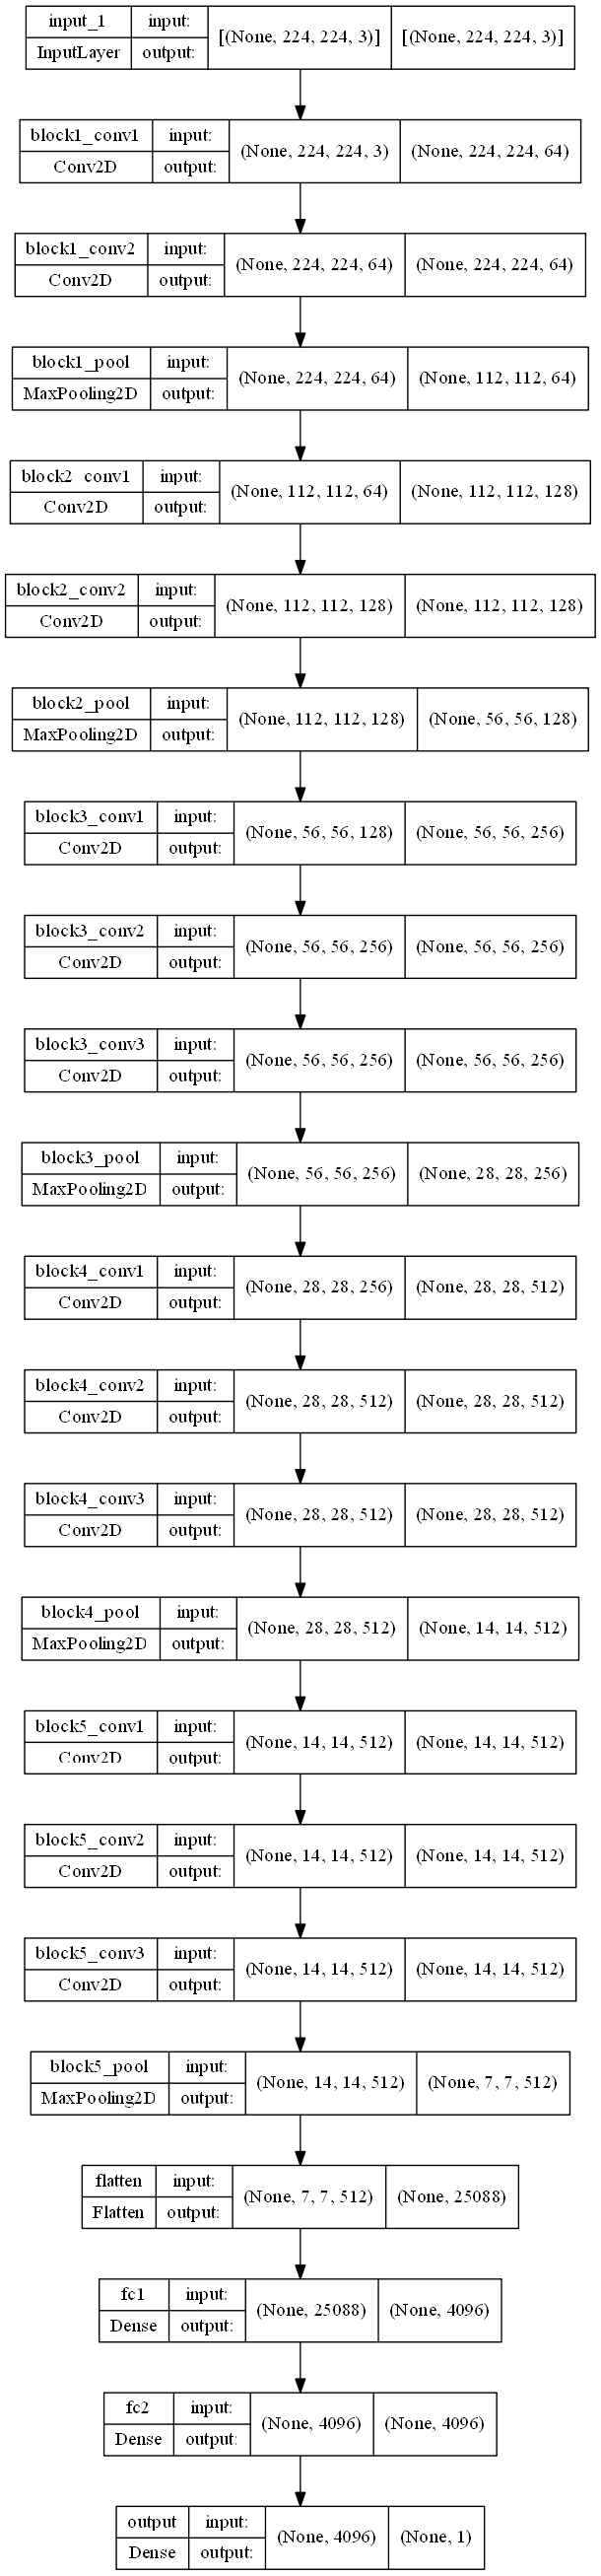

In [33]:
plot_model(vgg_model, to_file=vgg16_model_plot_path, show_shapes=True, dpi=100)

### Training

**Compile the model with necessary configs:**

* Here I will be using **Adam** optimiser to reach to the global minima while training out model. If I am stuck in local minima while training then the adam optimiser will help us to get out of local minima and reach global minima. We will also specify the **learning rate** of the optimiser, here in this case it is set at **0.001**. If our training is bouncing a lot on epochs then we need to decrease the learning rate so that we can reach global minima.

* **binary_crossentropy** function computes the cross-entropy loss between true labels and predicted labels.

* And metrics will be **accuracy**.


***If you don't want to train the model, you can skip this cell.***

In [23]:
vgg_model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate= 0.0001), metrics=['accuracy'])

**Train the model with callbacks function:**

* **ModelCheckpoint** - It helps us to save the model by monitoring a specific parameter of the model. In this case I am monitoring validation accuracy by passing `val_accuracy` to ModelCheckpoint. The model will only be saved to disk if the validation accuracy of the model in current epoch is greater than what it was in the last epoch.

* **EarlyStopping** - It helps us to stop the training of the model early if there is no increase in the parameter which I have set to monitor in EarlyStopping. In this case I am monitoring validation accuracy by passing `val_accuracy` to EarlyStopping. I have here set patience to `5` which means that the model will stop to train if it doesn’t see any rise in validation accuracy in 5 epochs.


***If you don't want to train the model, you can skip this cell.***

In [24]:
model_checkpoints = tf.keras.callbacks.ModelCheckpoint(
    "Breast_Cancer_VGG16_model.weights.best.h5", 
    save_best_only=True, 
    verbose=1, 
    mode='max', 
    monitor='val_accuracy'
)
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    mode="max",
    patience=5,
    verbose=1
)

callbacks = [
    model_checkpoints,
    early_stopping
]

**Model fitting**

Here, I will pass training and validation data, `epochs` is set to 100, `callbacks` and `verbose` is 2. 

***If you don't want to train the model, you can skip this cell.***

In [25]:
vgg_history = vgg_model.fit(
    train_batches, 
    validation_data=valid_batches, 
    epochs=100,
    callbacks=callbacks, 
    verbose=2
)

Epoch 1/100

Epoch 1: val_accuracy improved from -inf to 0.74375, saving model to Breast_Cancer_VGG16_model.weights.best.h5
45/45 - 295s - loss: 0.6660 - accuracy: 0.6132 - val_loss: 0.6516 - val_accuracy: 0.7437 - 295s/epoch - 7s/step
Epoch 2/100

Epoch 2: val_accuracy improved from 0.74375 to 0.77812, saving model to Breast_Cancer_VGG16_model.weights.best.h5
45/45 - 296s - loss: 0.5862 - accuracy: 0.7771 - val_loss: 0.6036 - val_accuracy: 0.7781 - 296s/epoch - 7s/step
Epoch 3/100

Epoch 3: val_accuracy improved from 0.77812 to 0.79062, saving model to Breast_Cancer_VGG16_model.weights.best.h5
45/45 - 298s - loss: 0.5401 - accuracy: 0.7906 - val_loss: 0.5735 - val_accuracy: 0.7906 - 298s/epoch - 7s/step
Epoch 4/100

Epoch 4: val_accuracy did not improve from 0.79062
45/45 - 297s - loss: 0.5104 - accuracy: 0.8014 - val_loss: 0.5577 - val_accuracy: 0.7750 - 297s/epoch - 7s/step
Epoch 5/100

Epoch 5: val_accuracy did not improve from 0.79062
45/45 - 297s - loss: 0.4899 - accuracy: 0.8031

**Store training history**

***If you don't want to train the model, you can skip this cell.***

In [58]:
with open(vgg16_model_history_path, 'w') as file:
    json.dump(vgg_history.history, file)

**Retrive training history**

Loading history from a JSON file.

In [36]:
with open(vgg16_model_history_path) as file:
    vgg_history_data = json.load(file)

**Plot the training and validation outcome**

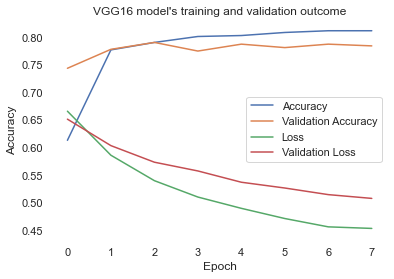

In [38]:
plt.plot(vgg_history_data["accuracy"])
plt.plot(vgg_history_data['val_accuracy'])
plt.plot(vgg_history_data['loss'])
plt.plot(vgg_history_data['val_loss'])
plt.title("VGG16 model's training and validation outcome")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy", "Validation Accuracy", "Loss", "Validation Loss"])
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.show()

**Save model**

In [29]:
vgg_model.save(vgg16_model_path)

### Evalutaion

Evaluate model on test data.

In [60]:
vgg_model_loss, vgg_model_accuracy = vgg_model.evaluate(test_batches, verbose=2)
print("Accuracy: {:5.2f}%".format(100 * vgg_model_accuracy))
print("Loss: {:5.2f}%".format(100 * vgg_model_loss))

13/13 - 81s - loss: 0.4926 - accuracy: 0.8062 - 81s/epoch - 6s/step
Accuracy: 80.62%
Loss: 49.26%


### Confusion Matrix

It visualizes and summarizes the performance of a classification algorithm.

*0 -> Non-IDC*

*1 -> IDC*

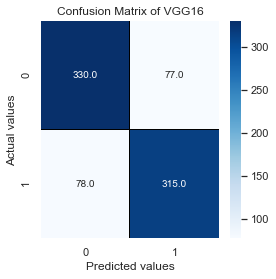

In [57]:
Y_pred_vgg = vgg_model.predict_generator(test_batches, test_df.shape[0] // batch_size+1)
y_pred_vgg = np.where(Y_pred_vgg >= 0.5, 1, 0).flatten()
vgg_cm = confusion_matrix(test_batches.classes, y_pred_vgg)
f,ax = plt.subplots(figsize=(4, 4))
sns.heatmap(vgg_cm, annot=True, linewidths=0.01, cmap="Blues", linecolor="black", fmt='.1f', ax=ax)
plt.xlabel("Predicted values")
plt.ylabel("Actual values")
plt.title("Confusion Matrix of VGG16")
plt.show()

### Classification Report

Here, we will have a performance evaluation metric where we can find **precision**, **recall**, **F1 Score**, and **support** of our trained model.

*0 -> Non-IDC*

*1 -> IDC*

In [59]:
print(classification_report(test_batches.classes, y_pred_vgg, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81       407
           1       0.80      0.80      0.80       393

    accuracy                           0.81       800
   macro avg       0.81      0.81      0.81       800
weighted avg       0.81      0.81      0.81       800



### Prediction

Load one Non-IDC and IDC picture, do prediction on our trained model.

*0 -> Non-IDC*

*1 -> IDC*

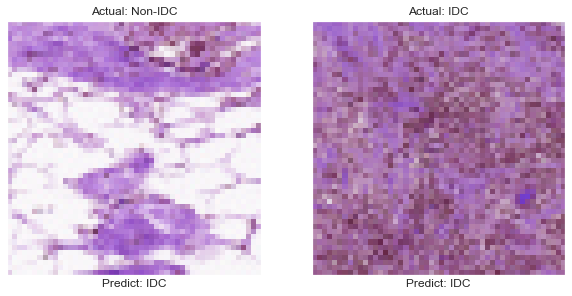

In [61]:
def prediction_for_vgg16(dataframe):
    plt.figure(figsize=(10,10))
    
    for i, v in enumerate([0, 799]):
        plt.subplot(1,2,i+1)
        image = cv2.imread(dataframe.loc[v, "path"])

        # create input data
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((224, 224))
        expand_input = np.expand_dims(resize_image, axis=0)
        input_data = np.array(expand_input)
        input_data = input_data/255

        # prediction
        prediction = vgg_model.predict(input_data)

        # plot the image
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image, cmap=plt.cm.binary)
        plt.title("Actual: %s" % ("Non-IDC" if int(dataframe.loc[v, "target"]) == 0 else "IDC") )
        plt.xlabel("Predict: %s" % ("IDC" if prediction >= 0.5 else "Non-IDC"))
        
    plt.show()

prediction_for_vgg16(test_df)